In [7]:

def Surface_Greens_1D(En, g, b, Us, layers):

    Energy = En # Energy
    z = 10**-8 # Imaginary Portion Added to Energy

    n = 1 # Atoms per layer
    P = 2 # Periodicity
    N = layers # Number of periods

    Gamma = g # Gamme
    Beta = b # Beta
    potential = Us # Potentail
    E = Energy+z*1j-potential

    # Create Hamiltonian
    alpha = np.zeros((n,n,P),dtype=complex)
    tau = np.zeros((n,n,P),dtype=complex)
    for i in range(P):
        alpha[:,:,i] = np.diag(potential*np.ones(n))
        if i%2 == 0:
            tau[:,:,i] = np.diag(Beta*np.ones(n))
        else:
            tau[:,:,i] = np.diag(Gamma*np.ones(n))

    H = np.zeros((N*P*n,N*P*n),dtype=complex)
    for i in range(N):
        for k in range(P):
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]
            
            if i*P+(k+1)<P*N:
                H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
                H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = np.conj(tau[:,:,k])
                
    # Condensation Algorithm ##################################################################
    C = H[n:P*n,n:P*n]
                
    C_tilde = inv(E*np.diag(np.ones((P-1)*n))-C)

    # Makes Condensation Matices
    Xi_s = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))
    Xi = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))+mul(tau[:,:,P-1],mul(C_tilde[(P-2)*n:(P-1)*n,(P-2)*n:(P-1)*n],tau[:,:,P-1].T.conj()))
    Pi = mul(tau[:,:,0],mul(C_tilde[0:n,(P-2)*n:(P-1)*n],tau[:,:,P-1]))

    # Condensed Matrix
    H_conds = np.zeros((N*n,N*n),dtype=complex)
    for i in range(N):
        if i == 0:
            H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi_s
        else:
            H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi
            H_conds[(i-1)*n:i*n,i*n:(i+1)*n] = Pi
            H_conds[i*n:(i+1)*n,(i-1)*n:i*n] = Pi.T.conj()
            
    # Eigenvalue Formulation ##################################################################
    # Eigenvalue Matrices
    A = np.zeros((2*n,2*n),dtype=complex)
    A[0:n,n:2*n] = np.diag(np.ones(n))
    A[n:2*n,0:n] = Pi.T.conj()
    A[n:2*n,n:2*n] = -(E*np.diag(np.ones(n))-Xi)
        
    B = np.zeros((2*n,2*n),dtype=complex)
    B[0:n,0:n] = np.diag(np.ones(n))
    B[n:2*n,n:2*n] = -Pi

    # Selcting eigenvalues with mag of less than one
    U = np.linalg.eig(mul(inv(B),A)).eigenvectors
    Lambda = np.linalg.eig(mul(inv(B),A)).eigenvalues

    indices = np.where(np.abs(Lambda) < 1)
    U = U[0:n,indices[0]]
    Lambda = np.diag(Lambda[indices[0]])

    # Pseudo invert U
    Q,R = np.linalg.qr(U)
    U_tilde = mul(inv(R),Q.T.conj())

    # Self Energy Matrix
    F = mul(U,mul(Lambda,U_tilde))
    Sigma_dash = mul(Pi,F)

    # Green's function
    g_00_eig = inv(E*np.diag(np.ones(n))-Xi_s-Sigma_dash)

    # Decimation Formulation ##################################################################
    # Initial matrices
    mu_0 = E*np.diag(np.ones(n))-Xi_s
    nu_0 = E*np.diag(np.ones(n))-Xi
    gamma_0 = Pi

    mu_old = mu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))
    nu_old = nu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))-mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0))
    gamma_old = mul(gamma_0,mul(inv(nu_0),gamma_0))
    zeta_old = mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0.T.conj()))

    # Iterative Procedure
    iterations = 40
    for i in range(iterations-1):
        mu_new = mu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))
        nu_new = nu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))-mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old))
        gamma_new = mul(gamma_old,mul(inv(nu_old),gamma_old))
        zeta_new = mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old.T.conj()))

        mu_old = mu_new
        nu_old = nu_new
        gamma_old = gamma_new
        zeta_old = zeta_new

    g_00_dec = inv(mu_new)
    
    # Recursive (Datta) Formulation ##################################################################
    g_old = (E-g**2)**(-1)
    
    for i in range(iterations):
        if i%2 == 0:
            g_new = (E-Gamma**2*g_old)**(-1)
        else:
            g_new = (E-Beta**2*g_old)**(-1)
        g_old = g_new

    g_00_rec = g_new

    # Direct Formulation ##################################################################
    g_surf_conds = inv(E*np.diag(np.ones(N*n))-H_conds)
    g_surf_conds_dir = g_surf_conds[0:n,0:n]

    g_surf = inv(E*np.diag(np.ones(N*P*n))-H)
    g_surf_dir = g_surf[0:n,0:n]

    g_quadratic = 1/(2*Gamma**2*E)*(E**2+Gamma**2-Beta*np.conj(Beta)-np.sqrt((E**2+Gamma**2-Beta*np.conj(Beta))**2-4*Gamma**2*E**2))
        

    return([g_00_eig[0,0],g_00_dec[0,0],g_00_rec,g_quadratic,g_surf_conds_dir[0,0],g_surf_dir[0,0]])

In [8]:
def Greens_1D(En, g, b, surface_g, layers):
    Energy = En # Energy
    z = 10**-8 # Imaginary Portion Added to Energy

    n = 1 # Atoms per layer
    P = 2 # Periodicity
    N = layers # Number of periods

    Gamma = g # Gamme
    Beta = b # Beta
    E = Energy+z*1j


    # Create Hamiltonian
    alpha = np.zeros((n,n,P),dtype=complex)
    tau = np.zeros((n,n,P),dtype=complex)
    for i in range(P):
        alpha[:,:,i] = np.diag(potential*np.ones(n))
        if i%2 == 0:
            tau[:,:,i] = np.diag(Beta*np.ones(n))
        else:
            tau[:,:,i] = np.diag(Gamma*np.ones(n))
   
    H = np.zeros((N*P*n,N*P*n),dtype=complex)
    for i in range(N):
        for k in range(P):
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]
            
            if i*P+(k+1)<P*N:
                H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
                H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = np.conj(tau[:,:,k])
          
    sigma = np.zeros((N*P*n,N*P*n),dtype=complex)
    sigma[0,0] = g**2*surface_g
    sigma[N*P-1,N*P-1] = g**2*surface_g
        
    return(inv(E*np.diag(np.ones(N*P*n))-H-sigma))

In [9]:
def calc_gamma_matrix(surface_g, g, layers,source):
    n = 1 # Atoms per layer
    P = 2 # Periodicity
    N = layers # Number of periods

    sigma = np.zeros((N*P*n,N*P*n),dtype=complex)
    
    if source == 1:
        sigma[0,0] = g**2*surface_g
    else:
        sigma[N*P-1,N*P-1] = g**2*surface_g
    
    return((sigma-sigma.T.conj())*1j)
    

In [11]:
# Test over several E values

Emin = -10
Emax = 0
stepsize = 0.01
Layers_probe = 2
Layers_device = 2

gamma_value = 2
beta_value = 2

ressults = np.zeros((int((Emax-Emin)/stepsize)+1,6),dtype=complex)
greens_func = np.zeros((int((Emax-Emin)/stepsize)+1,6,2*Layers_device,2*Layers_device),dtype=complex)

for i, E in enumerate(np.arange(Emin, Emax, stepsize)):
    ressults[i,:] = Surface_Greens_1D(E, gamma_value, beta_value, 0, Layers_probe)
    for k in range(6):
        greens_func[i,k,:,:] = Greens_1D(E, gamma_value, beta_value, ressults[i,k], Layers_device)

# Calculate Charge Density
charge_density = np.zeros((6,2*Layers_device,2*Layers_device),dtype=complex)

for i, E in enumerate(np.arange(-10, -5, stepsize)):
    for k in range(6):
        gamma_mat = calc_gamma_matrix(ressults[i,k],gamma_value,Layers_device,1)+ calc_gamma_matrix(ressults[i,k],gamma_value,Layers_device,0) 
        charge_density[k,:,:] += 2*mul(greens_func[i,k,:,:],mul(gamma_mat,greens_func[1,k,:,:].T.conj()))

# Calculate Current
current = np.zeros((int((Emax-Emin)/stepsize)+1,6),dtype=complex)
for i, E in enumerate(np.arange(Emin, Emax, stepsize)):
    for k in range(6):
        gamma_s = calc_gamma_matrix(ressults[i,k],gamma_value,Layers_device,1)
        gamma_d = calc_gamma_matrix(ressults[i,k],gamma_value,Layers_device,0) 
        if i ==0:
            current[i,k] = np.trace(mul(greens_func[i,k,:,:].T.conj(),mul(gamma_s,mul(greens_func[i,k,:,:],gamma_d))))    
        else:    
            current[i,k] = current[i-1,k]+np.trace(mul(greens_func[i,k,:,:].T.conj(),mul(gamma_s,mul(greens_func[i,k,:,:],gamma_d))))
                                       
                                       

matprint(current)

          8.11032e-25+0j   8.1102e-25-6.84228e-49j            8.16476e-25+0j            8.16476e-25+0j            8.11002e-25+0j            8.16425e-25+0j  
          1.63306e-24+0j            1.63304e-24+0j            1.64405e-24+0j            1.64405e-24+0j    1.633e-24+6.84228e-49j            1.64395e-24+0j  
2.46626e-24+6.84228e-49j            2.46622e-24+0j            2.48288e-24+0j            2.48288e-24+0j  2.46617e-24+6.84228e-49j  2.48273e-24+6.84228e-49j  
3.31078e-24+6.84228e-49j            3.31073e-24+0j  3.33314e-24-6.84228e-49j            3.33314e-24+0j  3.31066e-24+6.84228e-49j  3.33294e-24+6.84228e-49j  
 4.1668e-24+1.36846e-48j            4.16674e-24+0j  4.19501e-24-6.84228e-49j  4.19501e-24+6.84228e-49j  4.16665e-24+6.84228e-49j  4.19474e-24+1.36846e-48j  
5.03449e-24+1.36846e-48j            5.03442e-24+0j            5.06864e-24+0j  5.06864e-24+6.84228e-49j   5.0343e-24+6.84228e-49j  5.06832e-24+1.36846e-48j  
5.91403e-24+2.05268e-48j            5.91394e-24+0j        

2.06993e-18+8.51251e-43j  2.04824e-18-6.05249e-43j  2.31642e-18+9.48687e-43j  2.31642e-18+3.31549e-43j   2.01299e-18+3.2424e-43j  2.22928e-18+1.22597e-42j  
2.16045e-18+8.51251e-43j   2.1372e-18-7.84615e-43j  2.42056e-18+9.48687e-43j  2.42056e-18+3.31549e-43j  2.09938e-18+1.44874e-43j  2.32714e-18+1.22597e-42j  
2.25559e-18+1.03062e-42j  2.23068e-18-4.25883e-43j  2.53019e-18+9.48687e-43j  2.53019e-18+3.31549e-43j  2.19008e-18-3.44919e-44j     2.43e-18+1.22597e-42j  
2.35565e-18+1.03062e-42j  2.32894e-18-2.46516e-43j  2.64563e-18+5.89955e-43j  2.64563e-18+3.31549e-43j  2.28533e-18-2.13858e-43j  2.53813e-18+1.22597e-42j  
2.46091e-18+1.03062e-42j  2.43225e-18+1.12216e-43j  2.76725e-18+1.30742e-42j  2.76725e-18+3.31549e-43j   2.3854e-18-2.13858e-43j  2.65184e-18+1.22597e-42j  
2.57168e-18+1.03062e-42j  2.54093e-18+1.12216e-43j  2.89543e-18+1.66615e-42j  2.89543e-18+6.90281e-43j  2.49057e-18-2.13858e-43j  2.77148e-18+1.22597e-42j  
 2.6883e-18+1.03062e-42j  2.65529e-18+4.70948e-43j  3.0305

      382.5-4.93529e-16j        270.1+4.55636e-17j  1.60099e-06+9.79698e-26j         382.5-8.7777e-16j  2.35129e-10-9.49223e-32j  7.71469e-11-5.11707e-33j  
      383.5-4.93529e-16j      270.942+4.55636e-17j  1.60103e-06+9.79698e-26j        383.5-9.05526e-16j  2.35133e-10-9.49223e-32j  7.71475e-11-5.11707e-33j  
      384.5-5.07407e-16j        271.8+3.16858e-17j  1.60103e-06+9.79698e-26j        384.5-8.91648e-16j  2.35138e-10-9.49223e-32j   7.7148e-11-5.11707e-33j  
      385.5-5.07407e-16j      272.674+3.16858e-17j  1.60105e-06+9.79698e-26j         385.5-8.7777e-16j  2.35143e-10-9.49223e-32j  7.71485e-11-5.11707e-33j  
      386.5-5.07407e-16j       273.21+4.55636e-17j  1.60106e-06+9.79698e-26j         386.5-8.7777e-16j  2.35147e-10-9.49223e-32j   7.7149e-11-5.11707e-33j  
      387.5-5.07407e-16j      273.413+4.20942e-17j  1.60106e-06+9.79698e-26j         387.5-8.7777e-16j  2.35152e-10-9.49223e-32j  7.71495e-11-5.11707e-33j  
      388.5-5.07407e-16j      274.119+3.51553e-17j   1.601

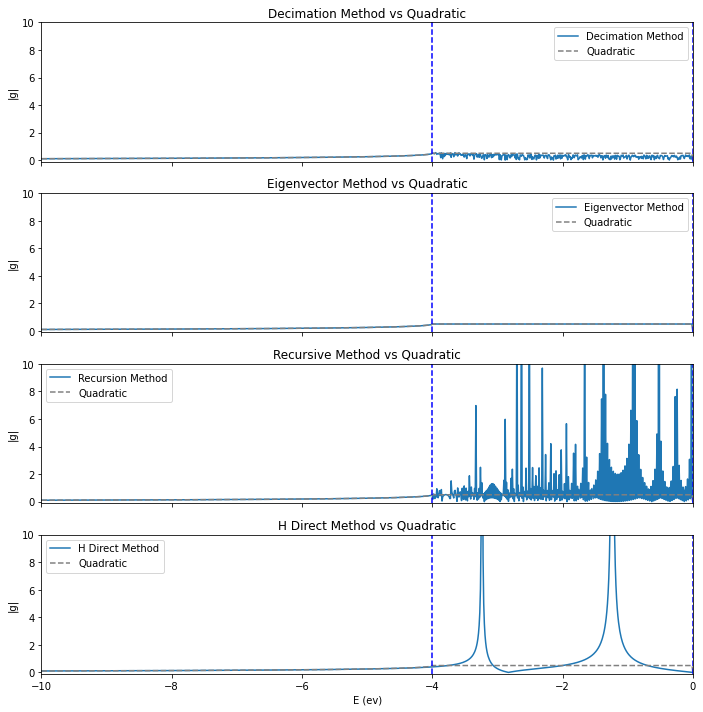

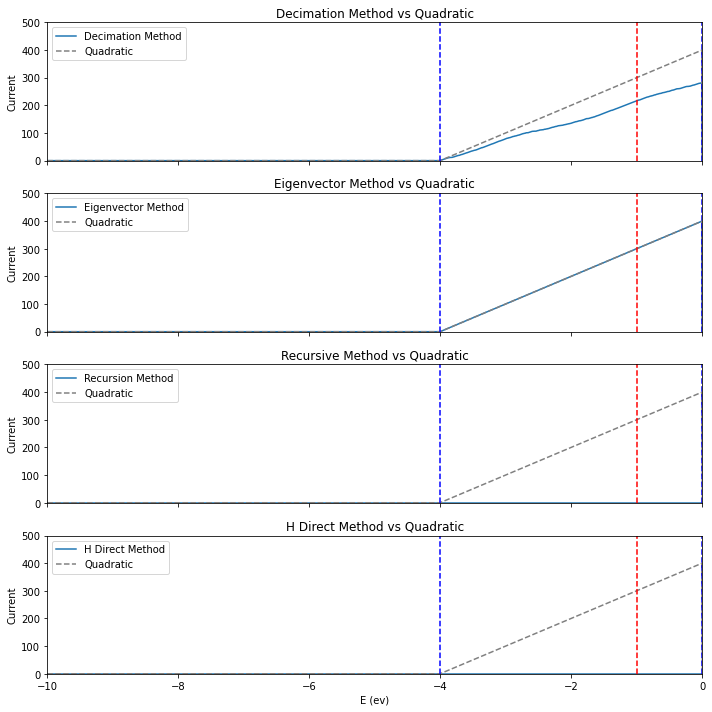

In [13]:
# Plotting 

x_values = np.linspace(Emin, Emax, int((Emax - Emin) / stepsize) + 1)

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x_values, abs(abs(ressults[:, 1])), label="Decimation Method")
axs[1].plot(x_values, abs(abs(ressults[:, 0])), label="Eigenvector Method")
axs[2].plot(x_values, abs(abs(ressults[:, 2])), label="Recursion Method")
axs[3].plot(x_values, abs(abs(ressults[:, 4])), label="H Direct Method")

# Plotting the quadratic case in each subplot
for ax in axs:
    ax.plot(x_values, abs(abs(ressults[:, 3])), label="Quadratic", linestyle='--', color='gray')

# Adding vertical lines
for ax in axs:
    ax.axvline(x=-(beta_value + gamma_value), color='b', linestyle='--')
    ax.axvline(x=-(-beta_value + gamma_value), color='b', linestyle='--')

axs[3].set_xlabel('E (ev)')
for ax in axs:
    ax.set_ylabel('|g|')
    ax.set_xlim(Emin, Emax)
    ax.set_ylim(-0.1, 10)
    ax.legend()

axs[0].set_title('Decimation Method vs Quadratic')
axs[1].set_title('Eigenvector Method vs Quadratic')
axs[2].set_title('Recursive Method vs Quadratic')
axs[3].set_title('H Direct Method vs Quadratic')

plt.tight_layout()
plt.show()


# Plotting 

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x_values, abs(abs(current[:, 1])), label="Decimation Method")
axs[1].plot(x_values, abs(abs(current[:, 0])), label="Eigenvector Method")
axs[2].plot(x_values, abs(abs(current[:, 2])), label="Recursion Method")
axs[3].plot(x_values, abs(abs(current[:, 4])), label="H Direct Method")

# Plotting the quadratic case in each subplot
for ax in axs:
    ax.plot(x_values, abs(abs(current[:, 3])), label="Quadratic", linestyle='--', color='gray')

# Adding vertical lines
for ax in axs:
    ax.axvline(x=-(beta_value + gamma_value), color='b', linestyle='--')
    ax.axvline(x=-(-beta_value + gamma_value), color='b', linestyle='--')
    ax.axvline(x=-1, color='r', linestyle='--')

axs[3].set_xlabel('E (ev)')
for ax in axs:
    ax.set_ylabel('Current')
    ax.set_xlim(Emin, Emax)
    ax.set_ylim(-0.1, 500)
    ax.legend()

axs[0].set_title('Decimation Method vs Quadratic')
axs[1].set_title('Eigenvector Method vs Quadratic')
axs[2].set_title('Recursive Method vs Quadratic')
axs[3].set_title('H Direct Method vs Quadratic')

plt.tight_layout()
plt.show()


In [14]:

# Define Conditions
import numpy as np
import sympy as sp
from numpy.linalg import inv
from numpy import matmul as mul

import time
import matplotlib.pyplot as plt

Energy = -8 # Energy
z = 10**-8 # Imaginary Portion Added to Energy
E = Energy+z*1j

oneD_test = True # Test for 1D chain
Gamma = 2 # Gamme
Beta = 2 # Beta
potential = 0 # Potentail

n = 1 # Atoms per layer
P = 2 # Periodicity
if oneD_test == True:
    n = 1
    P = 2
N = 3 # Number of periods



# Create Hamiltonian
alpha = np.zeros((n,n,P),dtype=complex)
tau = np.zeros((n,n,P),dtype=complex)
if oneD_test == False:
    for i in range(P):
        alpha[:,:,i] = (np.random.random((n,n)))+1j*(np.random.random((n,n)))
        tau[:,:,i] = (np.random.random((n,n)))+1j*(np.random.random((n,n)))
else:
    for i in range(P):
        alpha[:,:,i] = np.diag(potential*np.ones(n))
        if i%2 == 0:
            tau[:,:,i] = np.diag(Beta*np.ones(n))
        else:
            tau[:,:,i] = np.diag(Gamma*np.ones(n))


        
H = np.zeros((N*P*n,N*P*n),dtype=complex)
for i in range(N):
    for k in range(P):
        H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]
        
        if i*P+(k+1)<P*N:
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
            H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = np.conj(tau[:,:,k])
            
# Condensation Algorithm ##################################################################
C = H[n:P*n,n:P*n]
            
C_tilde = inv(E*np.diag(np.ones((P-1)*n))-C)

# Makes Condensation Matices
Xi_s = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))
Xi = alpha[:,:,0]+mul(tau[:,:,0],mul(C_tilde[0:n,0:n],tau[:,:,0].T.conj()))+mul(tau[:,:,P-1],mul(C_tilde[(P-2)*n:(P-1)*n,(P-2)*n:(P-1)*n],tau[:,:,P-1].T.conj()))
Pi = mul(tau[:,:,0],mul(C_tilde[0:n,(P-2)*n:(P-1)*n],tau[:,:,P-1]))

# Condensed Matrix
H_conds = np.zeros((N*n,N*n),dtype=complex)
for i in range(N):
    if i == 0:
        H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi_s
    else:
        H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi
        H_conds[(i-1)*n:i*n,i*n:(i+1)*n] = Pi
        H_conds[i*n:(i+1)*n,(i-1)*n:i*n] = Pi.T.conj()

        
# Eigenvalue Formulation ##################################################################
# Eigenvalue Matrices
A = np.zeros((2*n,2*n),dtype=complex)
A[0:n,n:2*n] = np.diag(np.ones(n))
A[n:2*n,0:n] = Pi.T.conj()
A[n:2*n,n:2*n] = -(E*np.diag(np.ones(n))-Xi)
    
B = np.zeros((2*n,2*n),dtype=complex)
B[0:n,0:n] = np.diag(np.ones(n))
B[n:2*n,n:2*n] = -Pi

# Selcting eigenvalues with mag of less than one
U = np.linalg.eig(mul(inv(B),A)).eigenvectors
Lambda = np.linalg.eig(mul(inv(B),A)).eigenvalues

indices = np.where(np.abs(Lambda) < 1)
U = U[0:n,indices[0]]
Lambda = np.diag(Lambda[indices[0]])

# Pseudo invert U
Q,R = np.linalg.qr(U)
U_tilde = mul(inv(R),Q.T.conj())

# Self Energy Matrix
F = mul(U,mul(Lambda,U_tilde))
Sigma_dash = mul(Pi,F)

# Green's function
g_00_eig = inv(E*np.diag(np.ones(n))-Xi_s-Sigma_dash)
print("Eigenvalue Method")
matprint(g_00_eig)

# Decimation Formulation ##################################################################
# Initial matrices
mu_0 = E*np.diag(np.ones(n))-Xi_s
nu_0 = E*np.diag(np.ones(n))-Xi
gamma_0 = Pi

mu_old = mu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))
nu_old = nu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))-mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0))
gamma_old = mul(gamma_0,mul(inv(nu_0),gamma_0))
zeta_old = mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0.T.conj()))

# Iterative Procedure ##################################################################
iterations = 10
for i in range(iterations-1):
    mu_new = mu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))
    nu_new = nu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))-mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old))
    gamma_new = mul(gamma_old,mul(inv(nu_old),gamma_old))
    zeta_new = mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old.T.conj()))

    mu_old = mu_new
    nu_old = nu_new
    gamma_old = gamma_new
    zeta_old = zeta_new

g_00_dec = inv(mu_new)
print("Decimation Method")
matprint(g_00_dec)

# Recursive (Datta) Formulation ##################################################################
if oneD_test == True:
    g_old = (E-Gamma**2)**(-1)
    
    for i in range(iterations):
        if i%2 == 0:
            g_new = (E-Gamma**2*g_old)**(-1)
        else:
            g_new = (E-Beta**2*g_old)**(-1)
        g_old = g_new
        
    g_00_rec = g_new
    print("Recursive Relation Datta")
    print(g_00_rec)

# Direct Formulation ##################################################################
g_surf_conds = inv(E*np.diag(np.ones(N*n))-H_conds)
g_surf_conds_dir = g_surf_conds[0:n,0:n]
print("Direct Condensed Method")
matprint(g_surf_conds_dir)

g_surf = inv(E*np.diag(np.ones(N*P*n))-H)
g_surf_dir = g_surf[0:n,0:n]
print("Direct Method")
matprint(g_surf_dir)

if oneD_test == True:
    g_quadratic = 1/(2*Gamma**2*(E-potential))*((E-potential)**2+Gamma**2-Beta*np.conj(Beta)-np.sqrt(((E-potential)**2+Gamma**2-Beta*np.conj(Beta))**2-4*Gamma**2*(E-potential)**2))
    print("Quadratic Formulation")
    print(g_quadratic)




Eigenvalue Method
-0.133975-1.91756e-10j  
Decimation Method
-0.133975-1.91746e-10j  
Recursive Relation Datta
(-0.13397459621538227-1.9337567296847763e-10j)
Direct Condensed Method
-0.133975-1.91756e-10j  
Direct Method
-0.133975-1.93375e-10j  
Quadratic Formulation
(-0.1339745962155614-1.9337567297406475e-10j)


In [15]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")